In [2]:
# This section is for pre-processing the raw data pulled in from Twitter
# This is to be run after the appropriate data has been pulled using the Twitter API and placed in data.csv

In [3]:
# First all relevant packages are imported
import pandas as pd
import numpy as np
import csv
import re
import preprocessor as p
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import SnowballStemmer
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import remove_stopwords
from afinn import Afinn

In [4]:
# Raw dataset is read in
twitter_df = pd.read_csv("data.csv")

In [5]:
# Basic pre-processing
# Drop line if not English
twitter_df = twitter_df[twitter_df.lang == 'en']
# Drop duplicates
twitter_df = twitter_df.drop_duplicates()
# Drop any NA texts
twitter_df['text'] = twitter_df['tweet'].dropna()
# Convert to lower case
twitter_df['text'] = twitter_df['text'].str.lower()
# Apply preprocessing package - suports cleaning of
# URLs, hashtags, mentions, reserved words, emojis and smileys
twitter_df['text'] = twitter_df['text'].apply(lambda x: p.clean(x))
# Get rid of non-letter characters
twitter_df['text'] = twitter_df['text'].apply(lambda x: re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', x))
# Lemmatization and stemming
# Define lemmatizer and stemmer from package
lmt = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
# Define  function from lemmatixation and stemming
def lemma_and_stem(strng):
    '''Word stemmer; find the root of the word. E.g. 'dogs' becomes 'dog'''
    strng = strng.lower()
    word = lmt.lemmatize(strng)
    word = stemmer.stem(strng)
    return word
# Apply function
twitter_df['text'] = twitter_df['text'].apply(lemma_and_stem)
# Remove all stopwords and tokenize in one
twitter_df['text'] = twitter_df['text'].apply(lambda x: remove_stopwords(x))
# Drop duplicates on text so only original left
twitter_df = twitter_df.drop_duplicates(subset=['text'])
# Finally tokenise text
# Processing done

In [6]:
# We also have to split the coordinates into two separate columns
twitter_df['coordinates'] = twitter_df['coordinates'].str.findall(r"(?<=\[)([^]]+)(?=\])")
# Split out coordinates
# Latitude
twitter_df['coordinates'] = twitter_df['coordinates'].astype(str)
new = twitter_df['coordinates'].str.split(" ", n=2, expand=True)
new[0] = new[0].str.extract(r"([-+]?\d*\.*\d+|\d+)", expand=False)
new[1] = new[1].str.extract(r"([-+]?\d*\.*\d+|\d+)", expand=False)
# Longitude
twitter_df['Latitude'] = new[0]
twitter_df['Longitude'] = new[1]
# Change created-at date to just day/month/year - no need for exact time in day
twitter_df['created_at'] = pd.to_datetime(twitter_df['created_at'])
twitter_df['created_at'] = twitter_df['created_at'].dt.tz_localize(None).dt.floor('d')
twitter_df['created_at'] = twitter_df['created_at'].apply(lambda x: x.strftime('%Y-%m-%d'))
# Coordinates done


In [7]:
# Now apply sentiment analysis with afinn package
# The Afinn package automativally downloads the lexicon but we have also provided raw versions of the
# lexicon in the data folder for your own convenience
afinn = Afinn()
afinn_scores = [afinn.score(text) for text in twitter_df['text']]
twitter_df['afinn'] = afinn_scores
# Translate this to a sentiment
def sentiment(row):
    if row['afinn'] == 0:
        sentiment = 'Neutral'
    if row['afinn'] > 0:
        sentiment = 'Positive'
    if row['afinn'] < 0:
        sentiment = 'Negative'
    return sentiment
# Apply sentiment function
twitter_df['Sentiment'] = twitter_df.apply(sentiment, axis=1)
# Generate colours
twitter_df['Sentiment'] = twitter_df['Sentiment'].astype(str)
def intensity(row):
        if row['Sentiment'] == 'Positive':
            val = 'blue'
        elif row['Sentiment'] == 'Negative':
            val = 'red'
        else:
            val = 'yellow'
        return val
twitter_df['Color'] = twitter_df.apply(intensity, axis=1)
twitter_df['text'] = twitter_df['text'].apply(word_tokenize)
# End of sentiment analysis

In [8]:
# Now we add two extra columns for sound and smell respectively
# Starting with smell
# Read in smell dictionary
smell_lines = open("lexicons/smell_dictionary_eng.txt", "r")
# Build smell words list
smell_read_in_file = smell_lines.readlines()
temporary_list = []
for element in smell_read_in_file:
    temporary_list.append(element.replace('\t',', '))
smell_list = []
for element in temporary_list:
    smell_list.append(element.strip())  
# Split into two lists for overall groupings and individual words
# We just want to see how many relate to smell
smell_words = []
perc_count = 0
for element in smell_list:
    if '%' in element:
        perc_count = perc_count + 1        
    if perc_count >= 2:
        smell_words.append(element)
# See how many words have something of interest to the current tweets set
def get_rid_of_perc(data_list):
    new_list = []
    for element in data_list:
        if '%' not in element:
            new_list.append(element)
    return new_list
# Apply to both lists
smell_words = get_rid_of_perc(smell_words)
# Just create list with smell words in it
smell_words_final = []
for element in smell_words:
    element = re.sub(r'([^a-zA-Z ]+?)','', element)
    element = re.sub('\W+', '', element)
    smell_words_final.append(element)

In [9]:
# Now we do the same process for sound
# Read in sound dictionary
sound_lines = open("lexicons/sound_dictionary_eng.txt", "r")
# Build sound words list
sound_read_in_file = sound_lines.readlines()
temporary_list = []
for element in sound_read_in_file:
    temporary_list.append(element.replace('\t',', '))
sound_list = []
for element in temporary_list:
    sound_list.append(element.strip())  
# Split into two lists for overall groupings and individual words
# We just want to see how many relate to sound
sound_words = []
perc_count = 0
for element in sound_list:
    if '%' in element:
        perc_count = perc_count + 1        
    if perc_count >= 2:
        sound_words.append(element)
# See how many words have something of interest to the current tweets set
def get_rid_of_perc(data_list):
    new_list = []
    for element in data_list:
        if '%' not in element:
            new_list.append(element)
    return new_list
# Apply to both lists
sound_words = get_rid_of_perc(sound_words)
# Just create list with smell words in it
sound_words_final = []
for element in sound_words:
    element = re.sub(r'([^a-zA-Z ]+?)','', element)
    element = re.sub('\W+', '', element)
    sound_words_final.append(element)

In [10]:
# Now we add the actual sound and smell columns
# Add sound column
def sound(row):
    text = row['text']
    value = 0
    for element in text:
        if element in sound_words_final:
            value = value + 1
    if value == 0:
        sound = "No"
    else:
        sound = "Yes"
    return sound
twitter_df['sound'] = twitter_df.apply(sound, axis=1)
# Add smell 
def smell(row):
    text = row['text']
    value = 0
    for element in text:
        if element in smell_words_final:
            value = value + 1
    if value == 0:
        smell = "No"
    else:
        smell = "Yes"
    return smell
twitter_df['smell'] = twitter_df.apply(smell, axis=1)

578128 words total, with a vocabulary size of 49031
Max tweet length is 90


C:\Users\patri\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


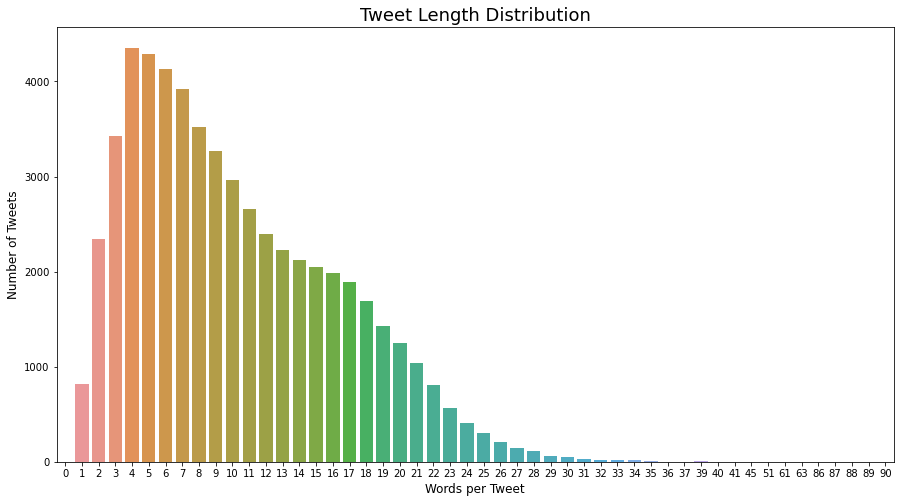

In [11]:
# Finally we visualise to make sure the output is appropriate from this
all_words = [word for tokens in twitter_df['text'] for word in tokens]
# Store all tweet lengths
tweet_lengths = [len(tokens) for tokens in twitter_df['text']]
# Store all the words sorted
vocab = sorted(list(set(all_words)))
print('{} words total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max tweet length is {}'.format(max(tweet_lengths)))
# PLot this graph
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (15,8))
sns.countplot(tweet_lengths)
plt.title('Tweet Length Distribution', fontsize = 18)
plt.xlabel('Words per Tweet', fontsize = 12)
plt.ylabel('Number of Tweets', fontsize = 12)
plt.show()
# EDA done

In [12]:
# Convert to back to CSV
twitter_df.to_csv("processed_dataset.csv")